In [44]:
import pandas as pd
from biolearn.data_library import DataLibrary
from biolearn.model_gallery import ModelGallery
import seaborn as sns
import matplotlib.pyplot as plt
gallery = ModelGallery()

In [115]:
data_path='/data/gladyshev/mm1286/data/'
man=pd.read_csv(data_path+'/aging-genes/man_e1.csv',index_col=0,usecols=['IlmnID','g','ch','pos','dis','gene'])

In [721]:
%%time
wb = DataLibrary().get("GSE112618").load()
mat=data_path+'ref/cell_comp/GSE110554_series_matrix.txt'
meta_a=pd.read_table(mat,nrows=10**2,skiprows=38,index_col=0).iloc[13].str.strip('cell type: ').drop(['GSM2998097','GSM2998106'])
meta_b=pd.read_table(mat,nrows=10**2,skiprows=38,index_col=0)[['GSM2998097','GSM2998106']].iloc[14].str.strip('cell type: ')
meta=pd.concat([meta_a,meta_b])
meta_m=meta[meta=='MIX']
meta=meta[meta!='MIX']
meta=pd.concat([meta,pd.Series('WB',index=wb.dnam.columns)])
dnam=pd.read_table(mat,nrows=10**6,skiprows=38+59,index_col=0)
dnam=dnam.drop('!series_matrix_table_end')
dnam=dnam.join(wb.dnam)
dnam_mix=dnam[meta_m.index]
meta_mix=pd.read_table(mat,nrows=10**2,skiprows=38,index_col=0).iloc[14:20][meta_m.index]
meta_mix.index=['CD4','CD8','B','NK','Mono','Neu']
for c in meta_mix.columns:
    meta_mix[c]=meta_mix[c].str.split(': ').str[1].astype(int)
meta_mix=meta_mix/100
mat2=data_path+'ref/cell_comp/GSE167998_matrix_processed.txt'
dnam2=pd.read_table(mat2,nrows=10**6,index_col=0,skiprows=0,usecols=[0]+list(range(1,136,2)))
meta2_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167998/matrix/GSE167998_series_matrix.txt.gz'
meta2=pd.read_table(meta2_,skiprows=38,index_col=0,nrows=1,header=None).T
meta2.index=dnam2.columns
meta2['!Sample_title']=meta2['!Sample_title'].str[:4]
meta2=meta2.squeeze()
meta_m2=meta2[meta2=='mem ']
meta2=meta2[meta2!='mem ']
meta2.loc[meta2.str[:2]=='Bn']='Bn'
meta2.loc[meta2.str[:2]=='Tn']='Tn'
meta2.loc[meta2.str[:2]=='NK']='NK'
meta2.loc[(meta2.str[:2]=='WB')|(meta2=='PCA0')|(meta2=='Neut')]='Neu'
dnam=dnam.join(dnam2)
meta=pd.concat([meta,meta2])

CPU times: user 24.9 s, sys: 3.27 s, total: 28.2 s
Wall time: 28.4 s


In [794]:
meta_mix2=pd.read_table(meta2_,skiprows=39,index_col=0,nrows=50).iloc[34:47]
meta_mix2.columns=dnam2.columns
meta_mix2=meta_mix2[meta_m2.index]
for c in meta_mix2.columns:
    meta_mix2[c]=meta_mix2[c].str.split(': ').str[1].astype(float)
meta_mix2.index=['treg','cd4n','cd4m','cd4','cd8','bn','bm','b','nk','mono','neu','eos','gran']    

In [560]:
epic_facs_salas_18 = DataLibrary().get("GSE112618").load()
cells=epic_facs_salas_18.metadata[['cd4t_proportion', 'cd8t_proportion', 'nk_proportion', 'bcell_proportion', 'monocytes_proportion','neutrophils_proportion']].astype(float)
types=['cd4','cd8','nk','b','mono','neut']
cells.columns=types
pred = gallery.get("DeconvoluteBloodEPIC").predict(epic_facs_salas_18).T;
pred.columns=['neut','nk','b','cd4','cd8','mono']
cors=[]
for c in types:
    cors.append(cells[[c]].corrwith(pred[c]).round(3).values[0])
cors=pd.Series(cors,index=types)    
cors

Estimating cell proportions using 'EPIC' platform reference...
Number of CpGs in reference: 600
Number of CpGs in methylation data intersecting with reference CpGs: 600
Running deconvolution...
Deconvolution complete!


cd4     0.991
cd8     0.960
nk      0.782
b       0.993
mono    0.983
neut    0.991
dtype: float64

In [844]:
umb_meta=pd.read_table(data_path+'ref/cell_comp/GSE180970_series_matrix.txt',skiprows=38,index_col=0,nrows=40).iloc[7:13]
umb_meta.index=['cd4','cd8','b','nk','mono','neu']
umb_meta=umb_meta.T
for c in umb_meta.columns:
    umb_meta[c]=umb_meta[c].str.split(': ').str[1].astype(float)/100

In [845]:
%%time
umb=pd.read_table(data_path+'ref/cell_comp/GSE180970_series_matrix.txt',skiprows=37+40,index_col=0)

CPU times: user 2.29 s, sys: 191 ms, total: 2.48 s
Wall time: 2.48 s


In [802]:
wb=epic_facs_salas_18.dnam

In [803]:
mix=dnam[meta_mix.columns]

In [804]:
cd4=dnam[meta[meta=='CD4T'].index]

In [870]:
t=pd.concat([wb,mix,dnam[meta_mix2.columns],umb],axis=1)
t.shape

(866092, 42)

In [876]:
tp=pd.DataFrame(pd.concat([cells['cd4'],meta_mix.loc['CD4'],meta_mix2.loc['cd4'],umb_meta['cd4']]))
tp.shape

(42, 1)

In [890]:
tp['type']=6*[0]+12*[1]+12*[2]+12*[3]

In [903]:
tt=t.T.join(tp)
tt.shape

(42, 866094)

In [ ]:
%%time
cors=[]
for i in range(0,4):
    cors.append(tt[tt['type']==i].corrwith(tt[0]))

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
cors_df=pd.concat(cors,axis=1)

In [913]:
cors_df.sort_values('m').head(10).index

Index(['cg01210399', 'cg06376547', 'cg12464177', 'cg22033073', 'cg11778706',
       'cg07901251', 'cg23075732', 'cg00219233', 'cg17518643', 'cg05044173'],
      dtype='object')

In [911]:
cors_df['m']=cors_df.mean(1)
cors_df.sort_values('m').head(50).join(man)

,0,1,2,3,m,ch,pos,g,dis,gene
cg01210399,-0.976250,-0.884398,-0.899680,-0.810632,-0.889456,1,84635169,1084635169,-55120,SSX2IP
cg06376547,-0.968339,-0.889072,-0.847990,-0.788148,-0.869978,15,63390221,15063390221,8375,CA12
cg12464177,-0.894650,-0.864440,-0.952018,-0.780181,-0.869117,17,35708249,17035708249,-23390,RASL10B
cg22033073,-0.943321,-0.878632,-0.877921,-0.788574,-0.868770,16,21596896,16021596896,-326,METTL9
cg11778706,-0.822270,-0.919614,-0.875602,-0.826279,-0.859394,8,22646038,8022646038,1234,BIN3
cg07901251,-0.967677,-0.787699,-0.839049,-0.813749,-0.849470,14,23033832,14023033832,-895,PSMB5
cg23075732,-0.908812,-0.841910,-0.848658,-0.791898,-0.845583,2,157784609,2157784609,-22387,ACVR1
cg00219233,-0.870346,-0.777369,-0.923582,-0.812658,-0.843244,7,44449284,7044449284,-41374,NUDCD3
cg17518643,-0.895220,-0.879406,-0.702811,-0.847613,-0.826125,13,99317018,13099317018,9619,GPR183
cg05044173,-0.899288,-0.846517,-0.785032,-0.780823,-0.826032,12,6789333,12006789333,-195,CD4


In [853]:
t.loc[['cg03855955']].T.corrwith(tp[0])

cg03855955   -0.702701
dtype: float64

<Axes: xlabel='0', ylabel='cg03855955'>

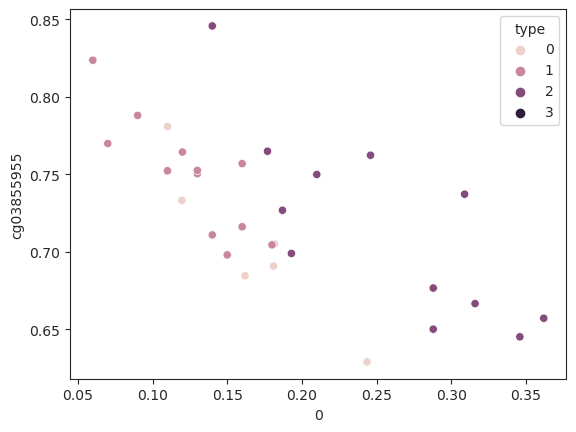

In [852]:
sns.scatterplot(x=tp[0],y=t.loc['cg03855955'],hue=tp['type'])

In [928]:
%%time
cd4n=t[meta_mix2.columns].T.corrwith(meta_mix2.loc['cd4n'])

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


CPU times: user 4min 20s, sys: 2.1 s, total: 4min 22s
Wall time: 10min 4s


In [929]:
cd4n.sort_values()

cg07650392                 -0.975633
cg22595657                 -0.968410
cg12518834                 -0.959513
cg07729711                 -0.959509
cg15165643                 -0.955367
                              ...   
cg27379210                       NaN
cg27509373                       NaN
cg27598632                       NaN
cg27634880                       NaN
!series_matrix_table_end         NaN
Length: 866092, dtype: float64

Text(0.5, 1.0, 'Deconvolution Validation - FACS')

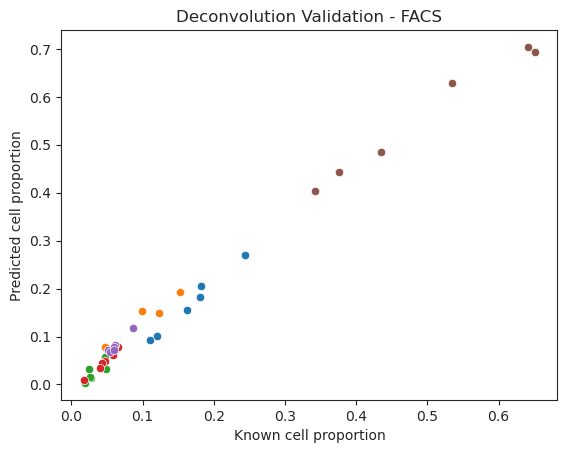

In [107]:
for cell in types:
    pl=pd.concat([cells[cell], pred[cell]],axis=1)
    pl.columns=['cell','pred']
    sns.scatterplot(data=pl,x='cell',y='pred')
plt.xlabel("Known cell proportion")
plt.ylabel("Predicted cell proportion")
plt.title("Deconvolution Validation - FACS")